In [2]:
import os 
import keras
import numpy as np 
from tqdm import tqdm 
import tensorflow as tf

import pandas as  pd
# Data 
import scipy.ndimage as mp
from glob import glob
import pathlib
import cv2 as cv
from keras.preprocessing.image import img_to_array, load_img
from tensorflow.image import resize
import tensorflow.image as tfi


# Data visualization
import matplotlib.pyplot as plt


from PIL import Image

import subprocess
from IPython.display import FileLink, display

from keras.utils import  Sequence


In [3]:
#ссылоки на изображения и маски
images = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/clip_img/*/*/*'))
masks = sorted(glob(r'../input/aisegmentcom-matting-human-datasets/matting/*/*/*'))

******** 


In [9]:

def distribution_mask_on_img(masks):
    mask_to_img_relation_list = []
    for m in masks:
        label = load_img(m)
        label = img_to_array(label)[:,:,0]
        label = np.where(label > 0, 1, 0)
        m_sum = np.sum(label) 
        mask_to_img_relation = m_sum/(label.shape[0]*label.shape[1])
        mask_to_img_relation_list.append(mask_to_img_relation)
    return mask_to_img_relation_list

In [11]:
mask_to_img_relation_list = distribution_mask_on_img(masks)

In [5]:
def see_pict(image, mask):
    plt.figure(figsize=(9, 5))
    plt.subplot(1,2,1)
    im = plt.imread(image)
    plt.imshow(im)
    plt.subplot(1,2,2)
    label = load_img(mask)
    label = img_to_array(label)[:,:,0]
    label = label != 0
    label = tf.cast(label/255.0, tf.float64)
    plt.imshow(label)
    plt.show()

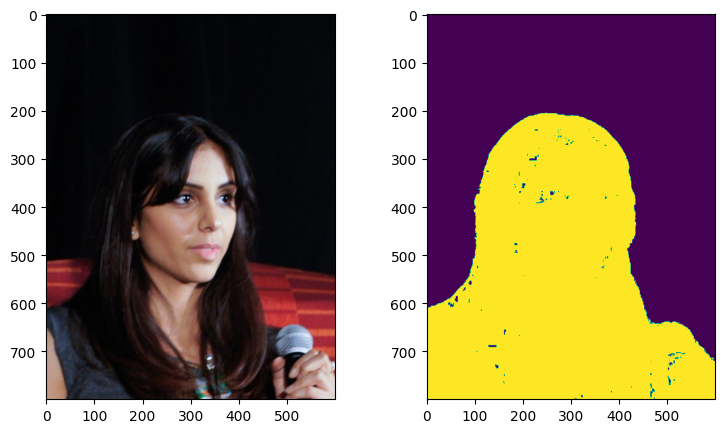

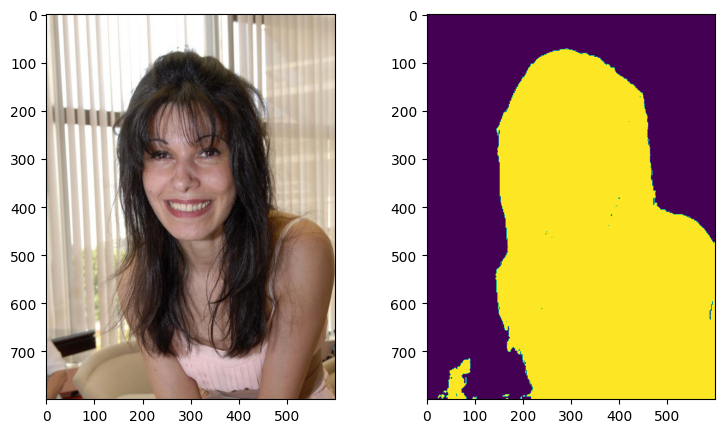

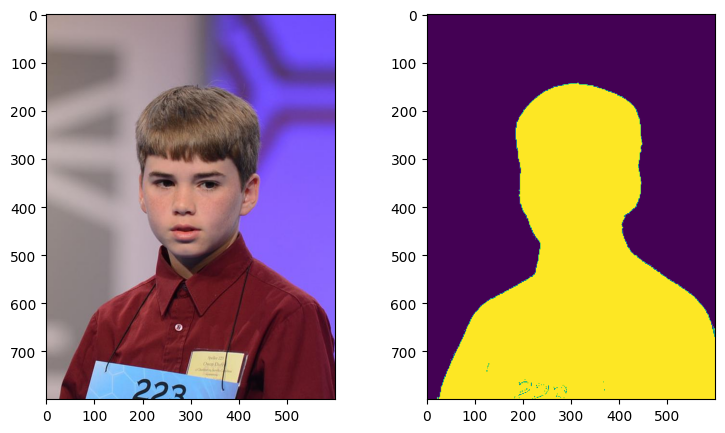

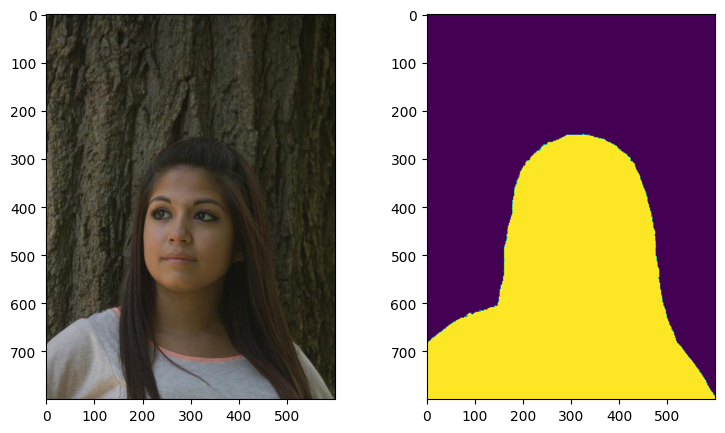

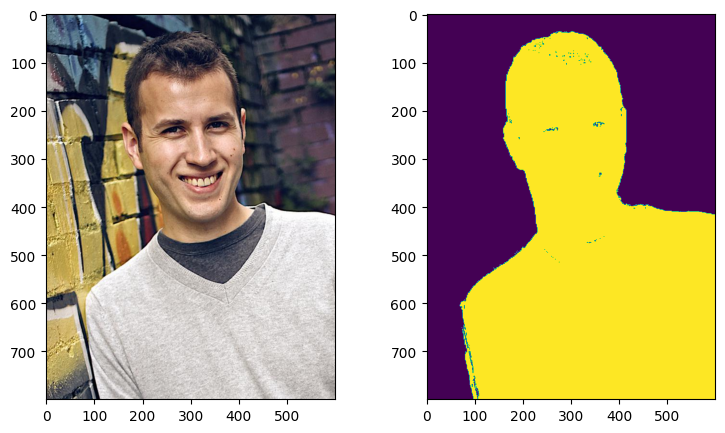

In [6]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    see_pict(image, mask)

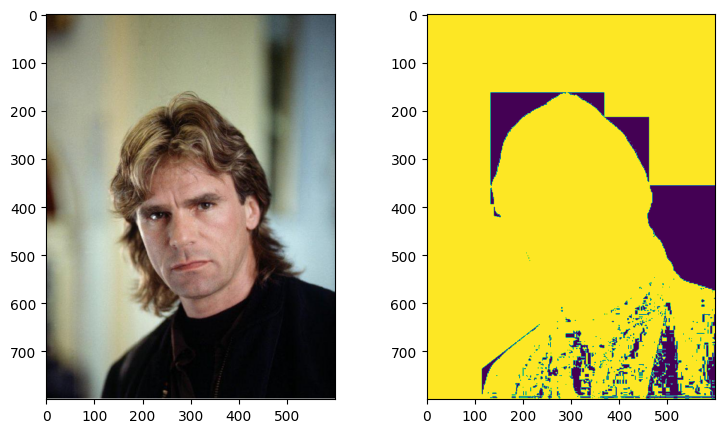

In [7]:
see_pict(images[87], masks[87])

## Problem
Often when we create a mask from png image we have mask with holes. It occurs becouse the black colour in image matrics equal 0. So if image have deep black collours it often have holes when we create mask some ways like mask = mask!=0. Also particulary this dataset probaly have  mask with some parts of bacground aspecialy when background have the skin or hair colours. The holes in the picture will be a big problem for educatiol provces.  
First - For model it is harder to remmember comprehansive mask with holes that the proper mask.  
Second - Even if we have a good models on our train and test dataset it works bad on real data. And our model will create hole in real picture so when we cut the image using mask we have this holes. It could make holes when peopel have deep black colour like eyse or hair.  
Below we try some trics to make a proper mask 


## Relation between mask size and image size

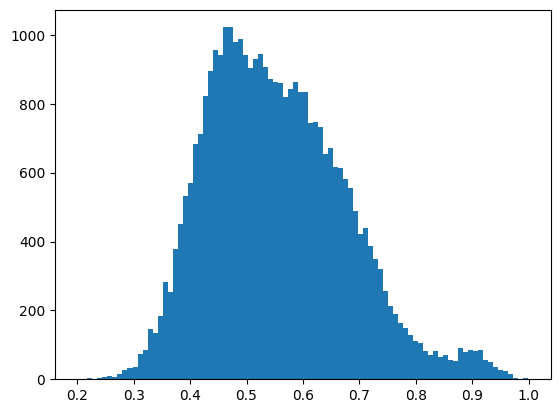

In [17]:
plt.hist(mask_to_img_relation_list, bins=90);

As we see on exapmle 87 some png mask containe a lot of BG. We gonna use the images and masks where mask take from 0.3 to 0.85 from image

## Manipulations with mask

In [52]:
def masking_problem(img, mask, method=None, multiply=False, transform=None, brightness = 100, contrast=100):
    
    plt.figure(figsize=(19, 5))
    plt.subplot(1,4,1)
    im = plt.imread(img)
    plt.title("Image")
    plt.imshow(im)
    
    plt.subplot(1,4,2)
    m = plt.imread(mask)
    plt.imshow(m)
    plt.title("Matting")
    
    plt.subplot(1,4,3)
    ml = m!=0
    ml=ml[:,:,0]
    plt.title("Mask without manipulations")
    plt.imshow(ml)

    plt.subplot(1,4,4)
    if method != None:
        m = tf.image.resize(m,(im.shape[0], im.shape[1]), method=method)
        m = m[:,:,0]
    if multiply != False:
        m = 10e7*m[:,:,0] + 10e7*m[:,:,1] + 10e7*m[:,:,2]
    elif method != None and transform != None and multiply != False:
        m = m[:,:,0]
    if transform != None:
        m = transform(m, contrast=contrast, brightness=brightness)
        m = m[:,:,0]
    
    m = m!=0
    plt.title("Mask with manipulations")
    plt.imshow(m)
    
  


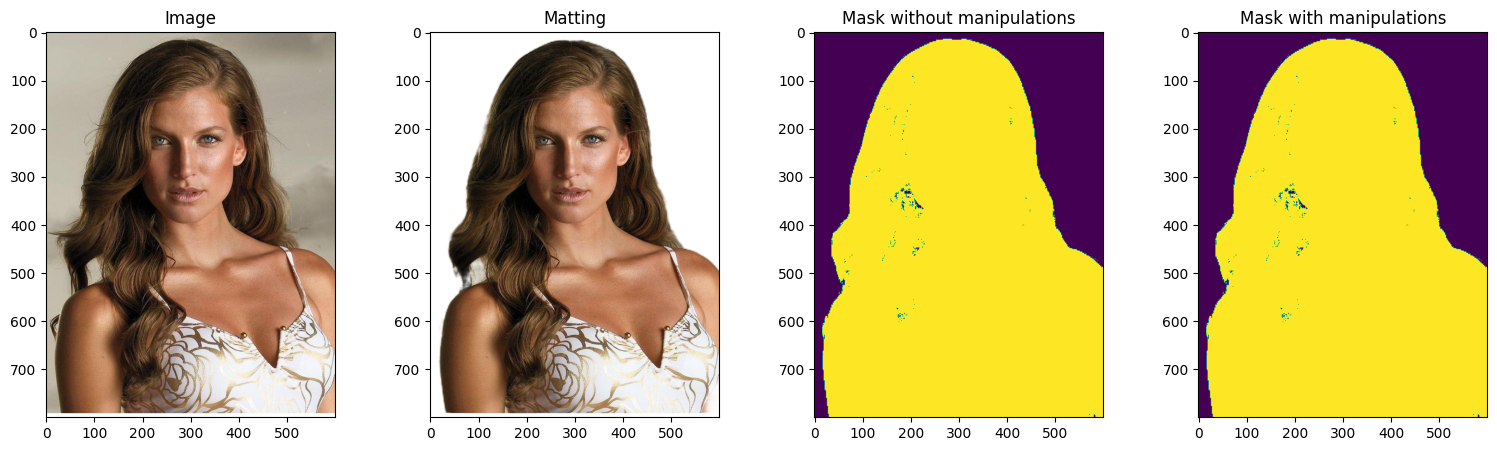

In [50]:
masking_problem(images[76], masks[76], method=None, multiply=False, transform=None,)

In [40]:
def brightnes_contrast(img, brightness = 100, contrast=100):
    img = np.int64(img)
    img = img * (contrast/127+1) - contrast + brightness
    img = np.clip(img, 0, 255)
    img = np.uint8(img)
    return img

## Sumaraize filtrs from png

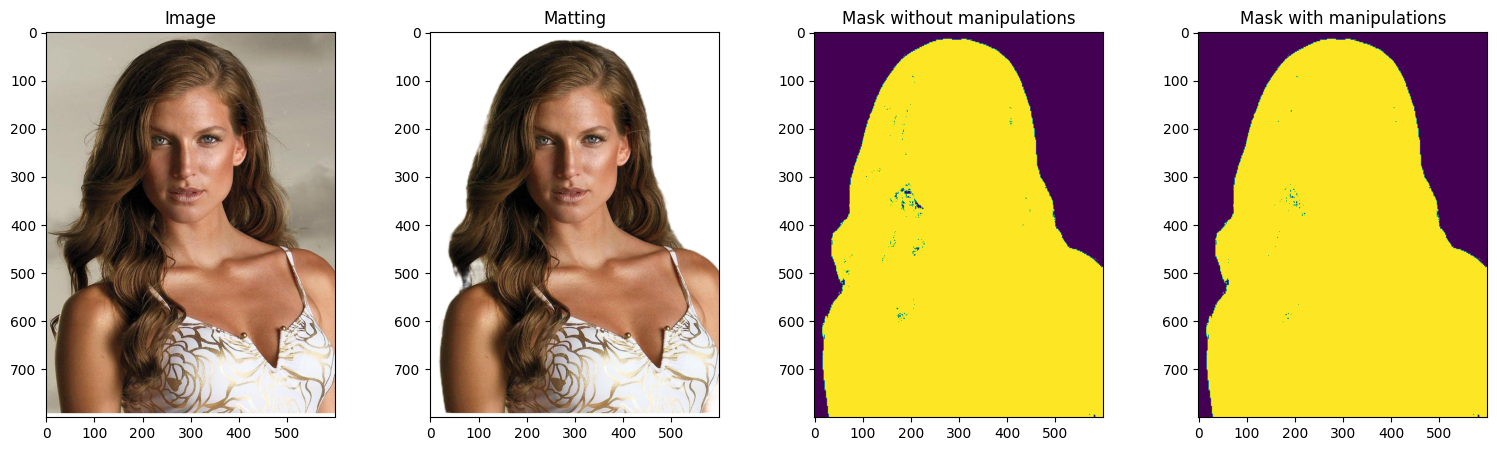

In [53]:
masking_problem(images[76], masks[76], method=None, multiply=True, transform=None,)

## Brightnes and Conrast

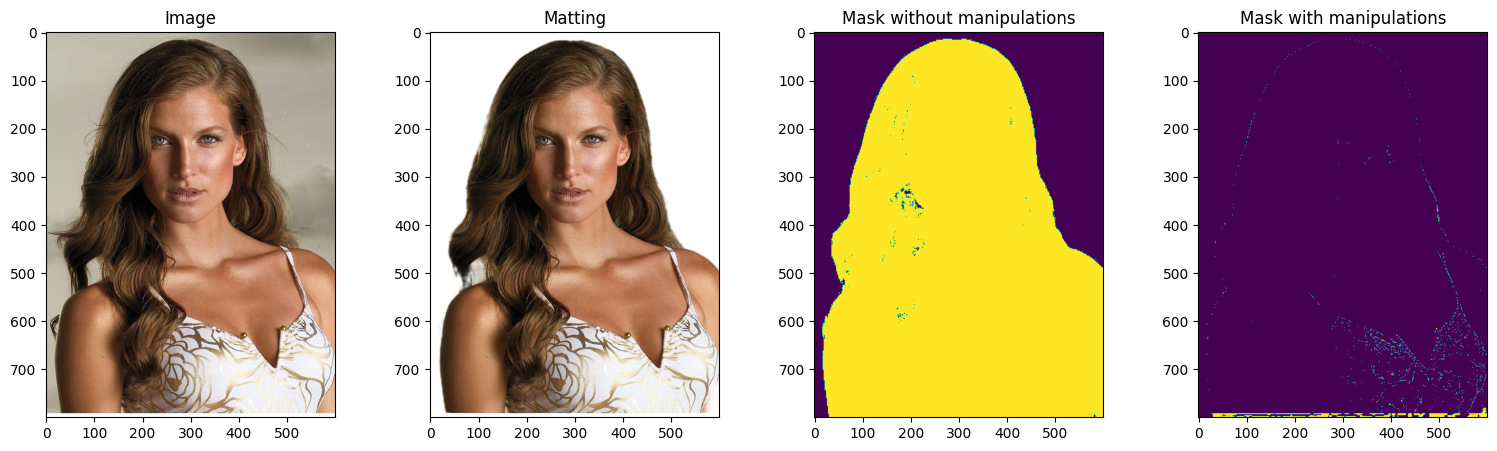

In [56]:
masking_problem(images[76], masks[76], method=None, multiply=False, transform=brightnes_contrast)

## Using ResizeMethod from Tensorflow

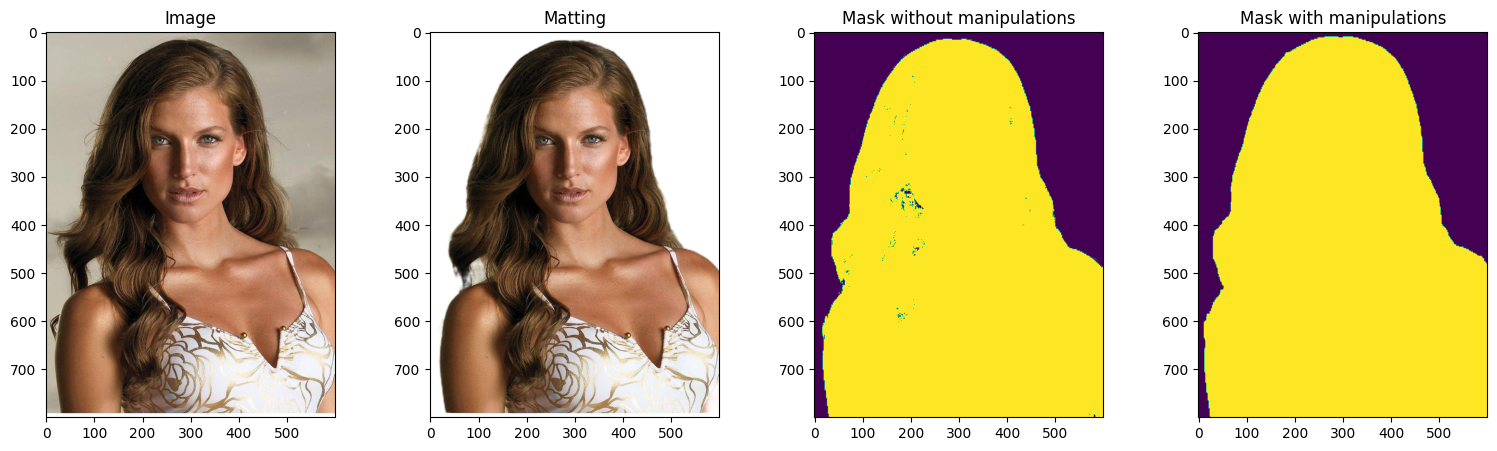

In [59]:
masking_problem(images[76], masks[76], method=tf.image.ResizeMethod.LANCZOS5, multiply=False, transform=None)

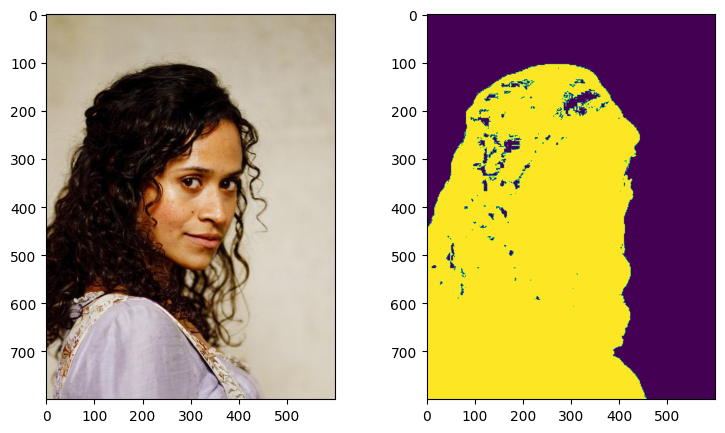

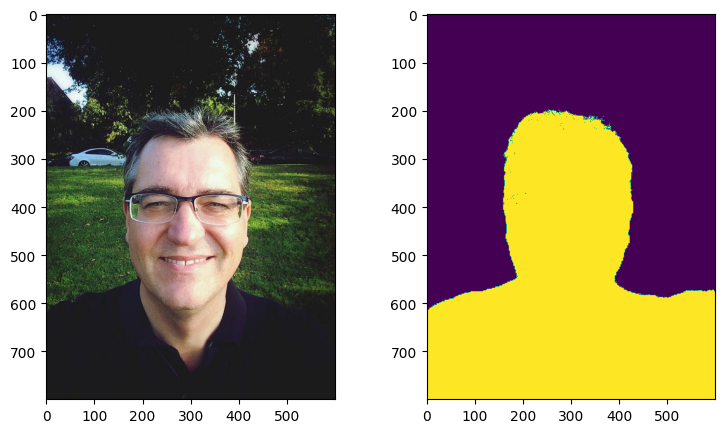

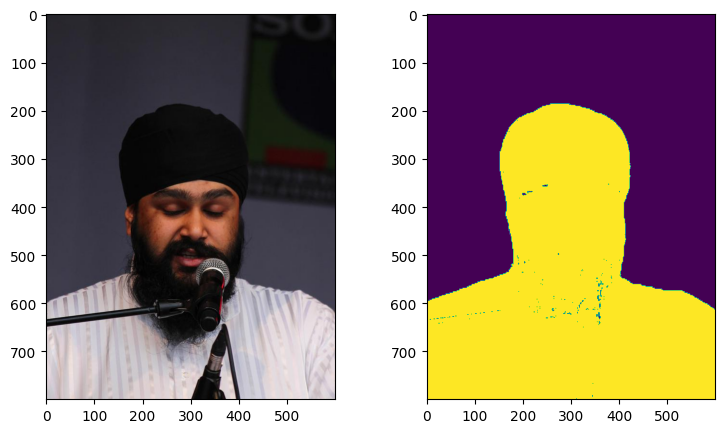

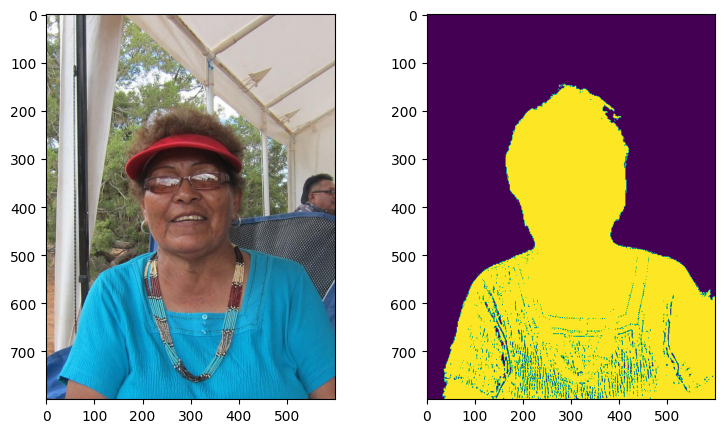

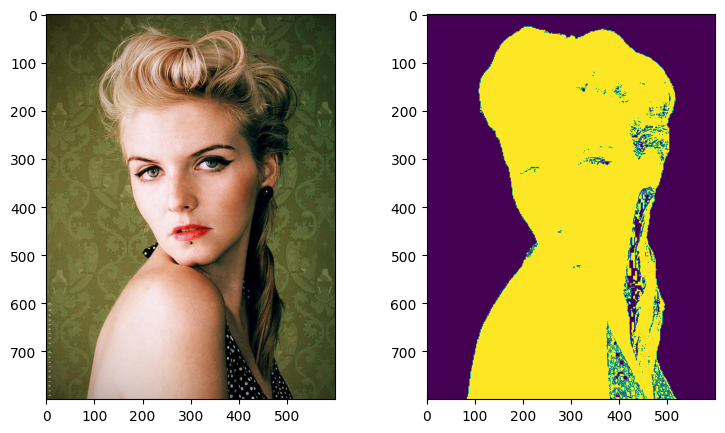

In [7]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    see_pict(image, mask)

## Using Scaning Vector String 

See for picture vector by vector (string) and fill with ones vector from first number to the last number if this number is not 0

In [9]:
def matting_solution(img, mask):
    # единственная проблема что не оч быстро работает
    # надо попробовать работать сразу со всей матрицей а не вектор строкой
        
    m = plt.imread(mask)
    m = m[:,:,0]
    m = (m[:,:]>0).astype(np.float16)
    
    for i, vector in enumerate(m):
        Z = np.zeros_like(vector)
        O = np.ones_like(vector)
        one_indexs = []
        
        for i2, el in enumerate(vector):
            if el > 0:
                one_indexs.append(i2)
        if one_indexs:
            Z[one_indexs[0]:one_indexs[-1]] = O[one_indexs[0]:one_indexs[-1]]
            m[i,:] = Z
            
            
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    image = cv.imread(img, cv.COLOR_BGR2RGB)
    image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
    plt.title("Исходное Изображение")
    plt.imshow(image)
        
    plt.subplot(1, 3, 2)
    plt.title("Маска")
    mask = cv.imread(mask)
    mask = (mask[:,:,0]>0).astype(np.float32) #mask = np.where(mask > 0, 1, mask)
    plt.imshow(mask)
        
    plt.subplot(1, 3, 3)
    
    plt.title("Измененая Маска")
    plt.imshow(m);
       

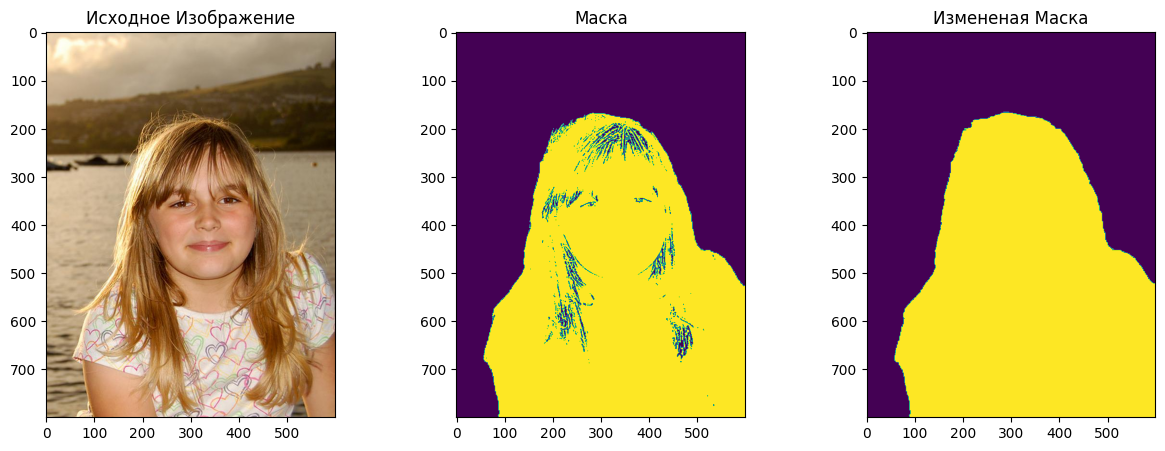

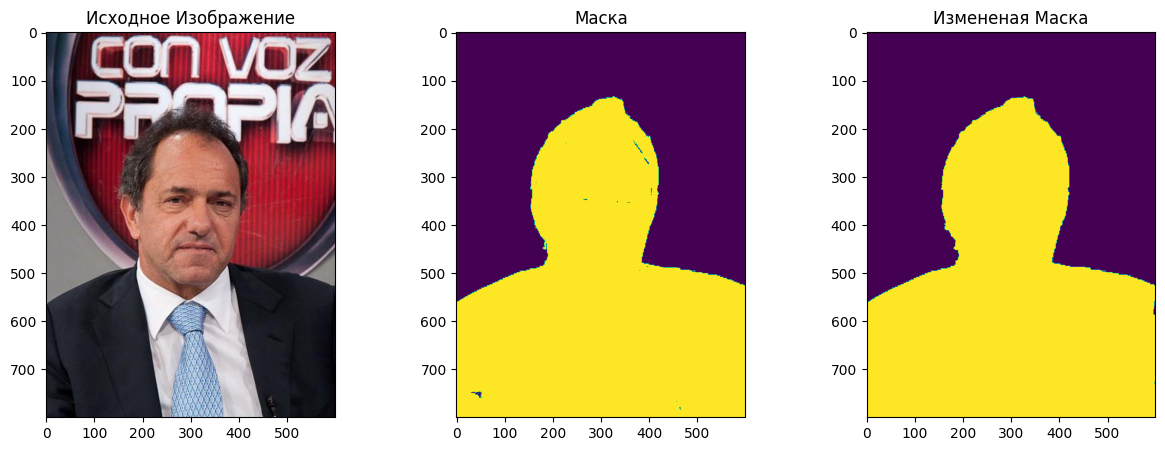

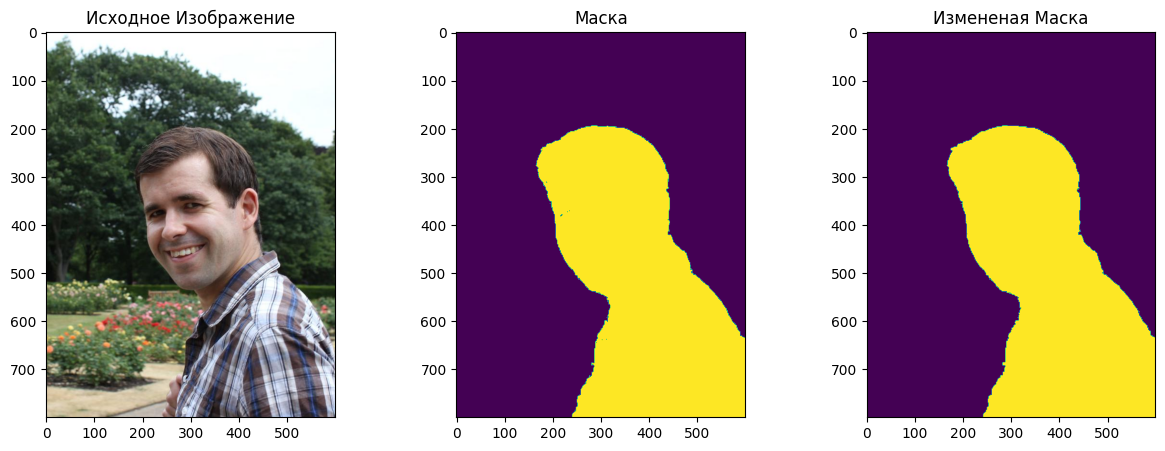

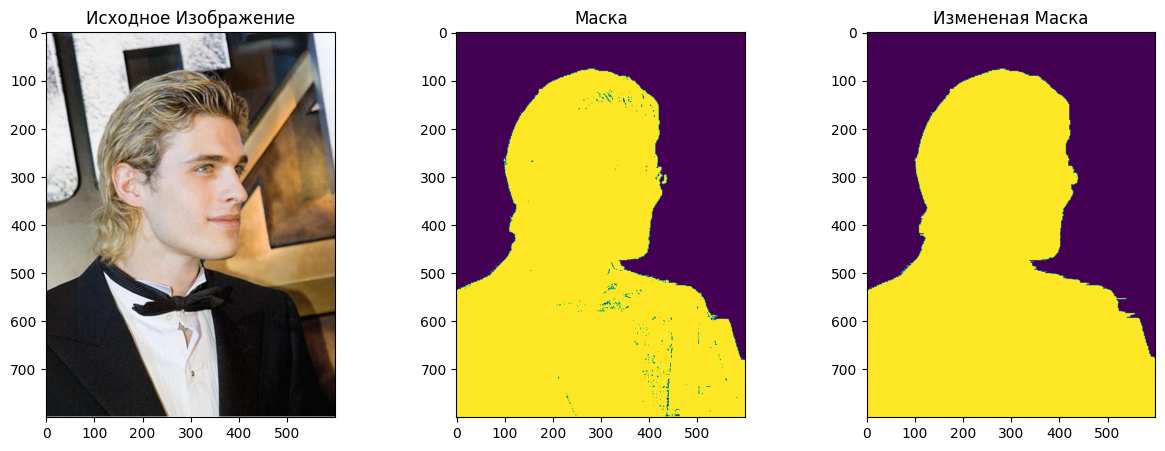

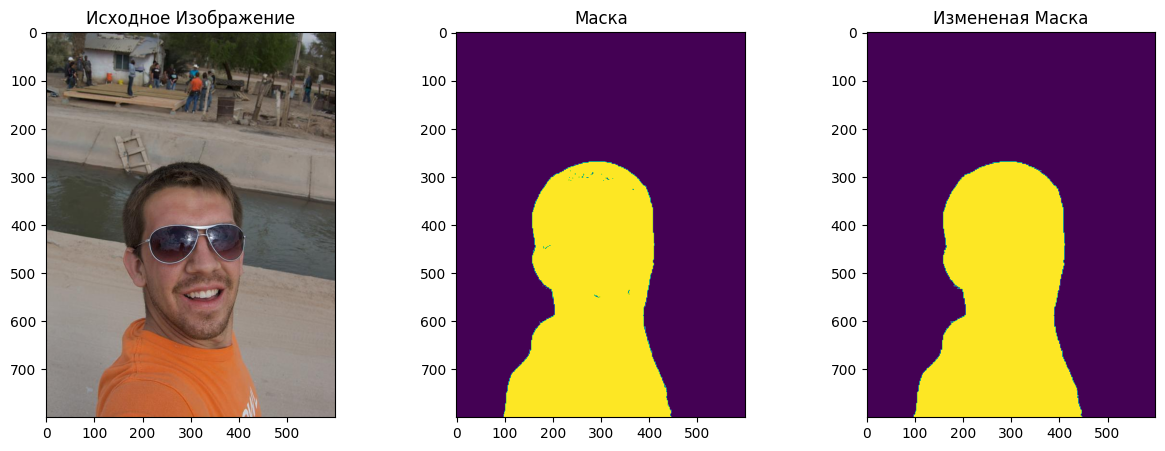

In [11]:
index = np.random.choice(range(len(images)), 5)
list_of_img = [images[i] for i in index]
list_of_mask =  [masks[i] for i in index]
for image, mask in zip(list_of_img, list_of_mask):
    matting_solution(image, mask)

## Matrics Scaning 
Using matrics for 

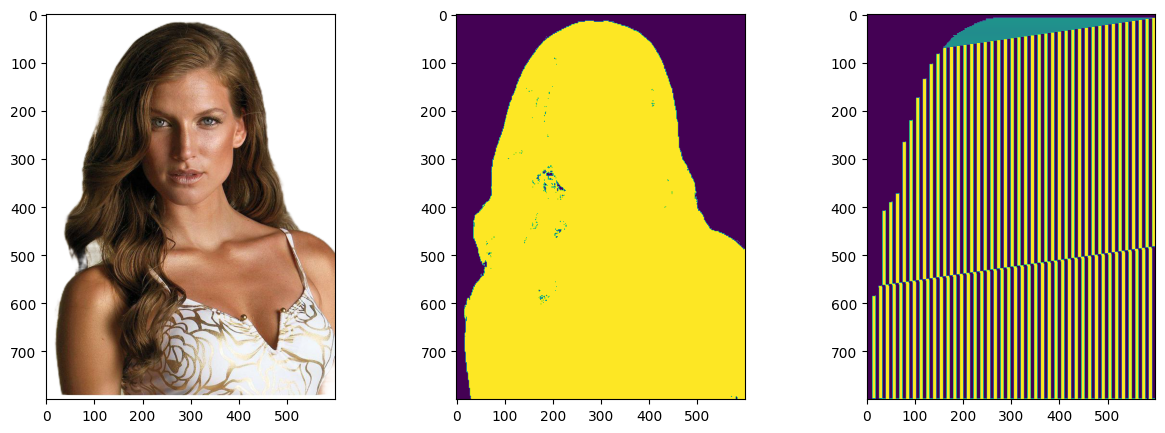

In [125]:
def matting_solution_matrix_trics(mask, size=9, step=4):
    plt.figure(figsize=(15,5))
    plt.subplot(1, 3, 1)
    M = plt.imread(mask)
    plt.imshow(M)
    M = M[:,:,0]
    M = (M[:,:]>0).astype(np.float16)
    plt.subplot(1,3,2)
    plt.imshow(M)
    i = 0
    j = 0
    half = M.shape[1]/2
    Z = np.zeros(size)
    O = np.ones(size)

    for i in range(M.shape[0]-size):
        # лок на строки
        n = i+size
        for j in range(M.shape[1]-size):
        
    #while i < M.shape[0]-size and j <  M.shape[1]-size: #по диагонали идет
            try:
                M_ = M[i: n, j: j+size]
                J = M[i: n, j+size] #vector 
                M_sum = np.sum(M_)
                J_sum = np.sum(J)
                if J_sum > 4:
                    M[i: n, j: j+size]= Z
                elif M_sum > 0 and J_sum <= 1:
                    M[i: n, j: j+size] = O
                #i, j = i + step, j+step
                #print(M_sum, J_sum)
            except (IndexError, ValueError):
                pass
            #print(M_sum, J_sum)
    
  

    plt.subplot(1,3,3)
    plt.imshow(M)
    plt.show()

    
            

matting_solution_matrix_trics(masks[76], size=7, step=3)